In [1]:
from src import main
ms = main.do_train()

import torch
from src import MODELS
runs_inx = 1
while (MODELS / f"runs_{runs_inx}.pth").is_file():
    runs_inx += 1
runs_savename = MODELS / f"runs_{runs_inx}.pth"
torch.save([x.models for x in ms], runs_savename)

/home/hugo_dev/.local/share/virtualenvs/inductive-bias-ruler-wJh1zHAp/lib/python3.10/site-packages/neptune/internal/backends/hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/hugo_dev/.local/share/virtualenvs/inductive-bias-ruler-wJh1zHAp/lib/python3.10/site-packages/pytorch_lightning/loggers/neptune.py:39: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune
/home/hugo_dev/.local/share/virtualenvs/inductive-bias-ruler-wJh1zHAp/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to th

https://new-ui.neptune.ai/interpretable-fewshot-kb-qa/Inductive-Bias-Ruler/e/IN-36


/home/hugo_dev/.local/share/virtualenvs/inductive-bias-ruler-wJh1zHAp/lib/python3.10/site-packages/pytorch_lightning/loggers/neptune.py:406: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'tuple'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  self.run[parameters_key] = params
/home/hugo_dev/.local/share/virtualenvs/inductive-bias-ruler-wJh1zHAp/lib/python3.10/site-packages/pytorch_lightning/loggers/neptune.py:406: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        Fo

Sanity Checking: 0it [00:00, ?it/s]

/home/hugo_dev/.local/share/virtualenvs/inductive-bias-ruler-wJh1zHAp/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9137406349182129     │
│         test_loss         │     6.345666408538818     │
└───────────────────────────┴───────────────────────────┘

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 15 operations to synchronize with Neptune. Do not kill this process.
All 15 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/interpretable-fewshot-kb-qa/Inductive-Bias-Ruler/e/IN-36/metadata


Training multiple models:  50%|█████     | 1/2 [00:35<00:35, 35.98s/it]

https://new-ui.neptune.ai/interpretable-fewshot-kb-qa/Inductive-Bias-Ruler/e/IN-37


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

/home/hugo_dev/.local/share/virtualenvs/inductive-bias-ruler-wJh1zHAp/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.867125391960144     │
│         test_loss         │    12.332598686218262     │
└───────────────────────────┴───────────────────────────┘

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 15 operations to synchronize with Neptune. Do not kill this process.
All 15 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/interpretable-fewshot-kb-qa/Inductive-Bias-Ruler/e/IN-37/metadata


Training multiple models: 100%|██████████| 2/2 [01:10<00:00, 35.33s/it]

Done


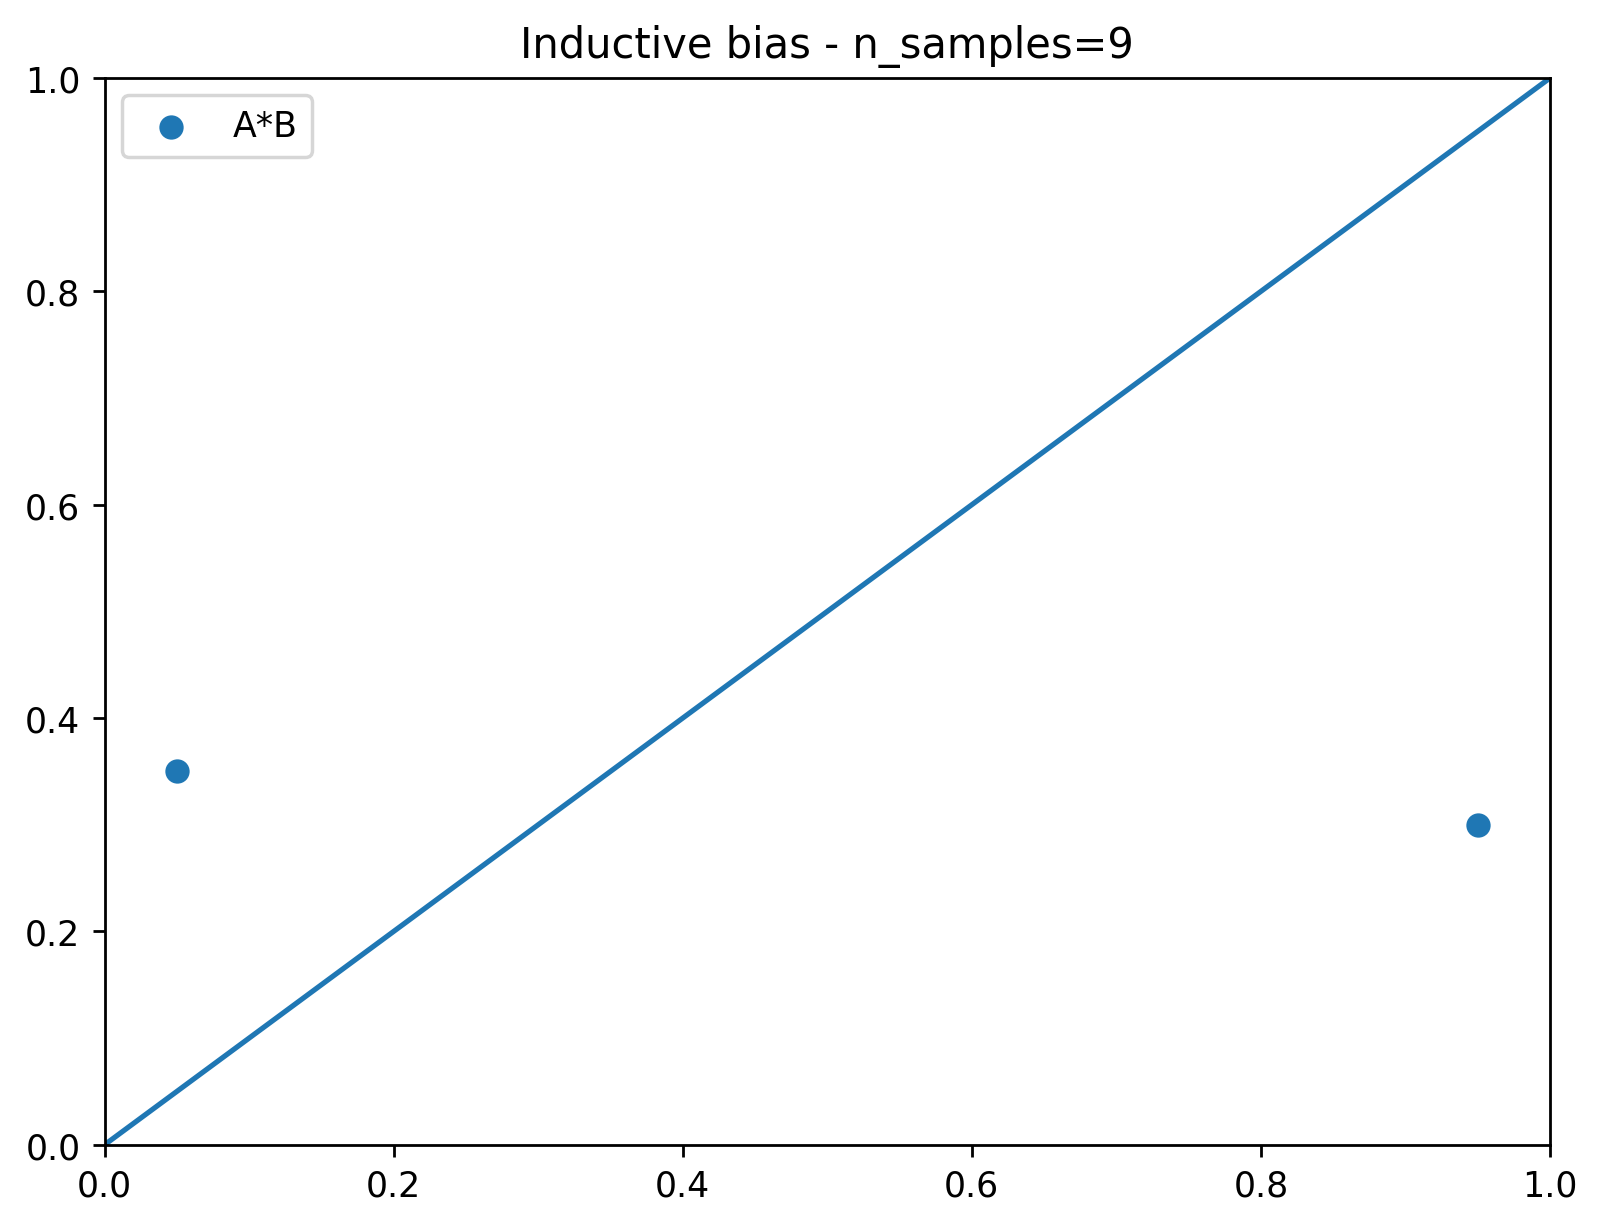

In [4]:
from src import datasets
import torch
from collections import Counter
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams["figure.dpi"] = 250
dm = datasets.MNISTDataModule()
ds = dm.get_test_dataset()
with torch.no_grad():
    signature_dists = None
    n_samples = 3
    while signature_dists is None or any(len(x) == 1 for x in signature_dists):
        signature_dists = []
        n_samples += 1
        sampling_inxs = list(range(n_samples))
        batch = torch.stack([ds[i][0] for i in sampling_inxs]).to("cuda")
        for model_ensemble in ms:
            ens_signature = []
            for model_out in model_ensemble.to("cuda")(batch).argmax(dim=-1):
                signature = tuple(model_out.tolist())
                ens_signature.append(signature)
            signature_dists.append(Counter(ens_signature))

labeled_signdists = {chr(ord("A")+i): dict(sd) for i, sd in enumerate(signature_dists)}
plot_order = list(labeled_signdists.keys())
n_ensembled = ms[0].n_ensembled
point_pairs = {}
for inx_a, labela in enumerate(plot_order):
    sda = labeled_signdists[labela]
    for labelb in plot_order[inx_a+1:]:
        sdb = labeled_signdists[labelb]
        pair_points = []
        for k, v in sda.items():
            pair_points.append((v / n_ensembled, sdb.get(k, 0) / n_ensembled))
        point_pairs[f"{labela}*{labelb}"] = pair_points

fig = plt.gcf()
ax = plt.gca()

for label, pts in point_pairs.items():
    ax.scatter(*zip(*pts), label=label)
ax.plot([0, 1], [0, 1])
fig.tight_layout()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title(f"Inductive bias - {n_samples=}")
plt.legend()
plt.show()